                                MEC-E5012 - Vehicle Mechatronics: Control       

# Exercise 2 (25 p)

### Important! : Make sure that you only write your code in the parts that we have explicitly asked you to. Do not edit other cells or parts of the code which we have not asked you to change. Feel free to play around with these other parameters after you have submitted your exercise.

## Python -  Lateral control

Your task is to implement both lateral controllers with the following tasks:

**Task 1: Lateral control: follow-the-carrot (6 p)**:
a steering controller, which is based on the error between the current heading and a heading that would direct to the target path

**Task 2: Lateral control: pure pursuit (7 p)**:
a geometric steering controller, which generates an arc to follow that leads to the target path

## Python - Uncertainty in Sensor Data

**Task 3: Tracking a vehicle with GPS (6 p)**: filtering noisy GPS measurements to more accurately position the vehicle

**Task 4: Tracking a vehicle with a fusion of GPS and odometry (6 p)**: additionally fusing noisy odometry data to position the vehicle even more accurately

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline
import time

### Preliminary grader to give you a reference on how good is your solution ###
def grader(t,v,v_ref,n):
    mae = (1/n)*np.sum(np.abs(v-v_ref))
    passed = True
    if t == 1 and mae > 0.03:
        passed = False
    if t == 2 and mae > 0.02:
        passed = False
    return mae, passed

def grader2(t, x1, y1, x2, y2):
    mae = np.mean(np.sqrt((x2-x1)**2 + (y2-y1)**2))
    passed = True
    if t == 3 and mae > 0.15:
        passed = False
    if t == 4 and mae > 0.10:
        passed = False
    return mae, passed

# Task 1: Follow-the-carrot
Here we introduce lateral control to the TurtleBot. We will utilize the <code>KinematicTurtle</code>-class developed in the exercise round 1.

In [2]:
class KinematicTurtle():
    def __init__(self):
        self.w1 = 0 # Wheel 1 speed
        self.w2 = 0 # Wheel 2 speed
        self.x = 0 # X coordinate
        self.y = 0 # Y coordinate
        self.theta = 0 # Heading
        self.w = 0 # Angular speed
        self.v = 0 # Speed
        
        self.l = 0.16 # Wheelbase
        self.r = 0.033 # Wheel radius
        self.v_max = 0.22 # Maximum speed
        self.w_max = 2.84 # Maximum angular speed
        
        self.Kp = 0.7
        self.la = 0.4
        
        self.sample_time = 0.3
        
    def vw_step(self, v, w):
        self.x = self.x + v*np.cos(self.theta)*self.sample_time
        self.y = self.y + v*np.sin(self.theta)*self.sample_time
        
        self.w1 = ((2*v + w*self.l)/(2*self.r))
        self.w2 = ((2*v - w*self.l)/(2*self.r))
        self.theta = self.theta + (self.r*(self.w1 - self.w2)/self.l)*self.sample_time
        
    def reset(self):
        self.w1 = 0 # Wheel 1 speed
        self.w2 = 0 # Wheel 2 speed
        self.x = 0 # X coordinate
        self.y = 0 # Y coordinate
        self.theta = 0 # Heading
        self.w = 0 # Angular speed
        self.v = 0 # Speed

This task is about implementing follow-the-carrot (FTC) control, which was presented in this week's lecture. Simply put, the controller looks ahead to a goal point in the future of the target path and tries to adjust the angle so that the current heading and the heading from the car to the goal point are the same. The controller gets its name from the reseblance of donkey following a carrot, its only purpose being to focus on the carrot and go that way.

The follow-the-carrot control is defined as the <code>ftc</code>-function. The following steps are required to implement the control:

1. Define the index of the closest point in the target path
2. Find the index of the goal point by travelling along the curve the distance of at least lookahead distance (<code>self.la</code>)
3. Define the goal point <code>xg, yg</code>
4. Calculate the angle error (difference between current heading and goal point)
5. define <code>steer</code> as the product of angle error and proportional gain (<code>self.Kp</code>)

In [3]:
class KinematicTurtle(KinematicTurtle):
    def ftc(self, xt, yt):
        
        ### YOUR CODE HERE ~10 LINES ###
        dist_array = []
        # 1. Index of closest point in path 
        for i in range(xt.shape[0]):
            temp_dist = np.sqrt(np.square(xt[i] - self.x) + np.square(yt[i] - self.y))
            dist_array.append(temp_dist)
        
        closest_pt_idx = np.argmin(dist_array)

        # 2. Index of goal point in path 
        c_la = closest_pt_idx
        dist_bound = 0
        while dist_bound < self.la:
            dist_bound = dist_bound + np.sqrt(np.square(xt[c_la + 1] - xt[c_la]) + 
                                              np.square(yt[c_la + 1] - yt[c_la])) 
            c_la = c_la + 1
            
        # 3. Define goal point 
        # The goal point
        xg = xt[c_la]
        yg = yt[c_la]
        
        ###
        
        # Angle between current heading and goal point
        alpha = np.arctan((yg-self.y)/(xg-self.x))
        # Angle error
        angle_error = alpha - self.theta
        steer = self.Kp * angle_error
        ###
        return steer, [self.x, xg], [self.y, yg]

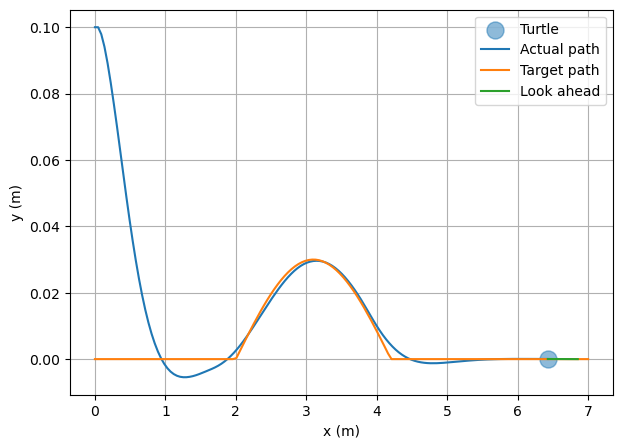

< --- Grading based on velocity accuracy --- >
Your Turtlebot followed the target path within 0.01 m mean absolute error

✅ Looking good, the error is quite low!


In [5]:
model = KinematicTurtle()
model.reset()
t = 43

t_data = np.arange(0,t,model.sample_time)
x_data = np.zeros_like(t_data)
y_data = np.zeros_like(t_data)

# Target path to follow
xt = np.linspace(0,7,num = t_data.shape[0])
yt = np.zeros_like(t_data)

# bump
a, b, amp = 2.0, 4.2, 0.03
mask = (xt >= a) & (xt <= b)
yt[mask] += amp * np.sin(np.pi * (xt[mask] - a)/(b - a))
model.y = 0.10 # starting offset

def live_plot(x, y, xl, yl, figsize=(7,5)):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    plt.scatter(x[-1], y[-1], s=150, alpha=0.5, label='Turtle')
    plt.plot(x, y, label= "Actual path")
    plt.plot(xt, yt, label="Target path")
    plt.plot(xl, yl, label="Look ahead")
    plt.grid(True)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.legend()
    plt.show();

x = []
y = []
for i in range(t_data.shape[0]):
    # For grading
    x_data[i] = model.x
    y_data[i] = model.y
    [steer, xl, yl] = model.ftc(xt,yt)
    
    # For liveplotting
    x.append(model.x)
    y.append(model.y)
    live_plot(x, y, xl, yl)
    
    # For model updating
    model.vw_step(0.15, steer)

# Grading [THIS IS NOT AUTOMATIC GRADER, JUST TO ASSIST IN GRADING]
mae, passed = grader(1, y_data, yt, t_data.shape[0])
print('< --- Grading based on velocity accuracy --- >')
print('Your Turtlebot followed the target path within %.2f m mean absolute error' % (mae))
print()
if passed:
    print('✅ Looking good, the error is quite low!')
else:
    print('⚠️ Over 0.03 m mean absolute error. Improve your model to reduce the error.')

# Task 2: Pure pursuit

This is a bit more tricky. It gets its name for literally looking ahead at the target path trying to chase that point pure based on geometrical arc between the current location and the target point. The following steps are required to implement the control:

1. Define the index of the closest point in the target path
2. Find the index of the goal point by travelling along the curve the distance of at least lookahead distance (<code>self.la</code>)
3. Define the goal point <code>xg, yg</code>
4. Define the goal point in vehicle coordinates
5. Calculate the length of the lookahead line: <code>L</code>
6. Calculate the yl (refer to the lecture slide picture of the Pure pursuit)
7. Calculate the radius of the turning arc and take the inverse of it to get the steering command: <code>gamma</code>


In [8]:
class KinematicTurtle(KinematicTurtle):
    def pure_pursuit(self, xt, yt):
        
        ### YOUR CODE HERE ~15 LINES ###
        dist_array = []
        # 1. Index of closest point in path 
        for i in range(xt.shape[0]):
            temp_dist = np.sqrt(np.square(xt[i] - self.x) + np.square(yt[i] - self.y))
            dist_array.append(temp_dist)
        
        closest_pt_idx = np.argmin(dist_array)
    
    
        # 2. Index of goal point in path 
        c_la = closest_pt_idx
        dist_bound = 0
        while dist_bound <= self.la:
            dist_bound = dist_bound + np.sqrt(np.square(xt[c_la + 1] - xt[c_la]) + 
                                              np.square(yt[c_la + 1] - yt[c_la])) 
            c_la = c_la + 1
            
        # 3. Define goal point 
        # The goal point
        xg = xt[c_la]
        yg = yt[c_la]
        
        # 4. Define goal point in vehicle coords 
        xgv = ((xg - self.x) * np.cos(self.theta))  + ((yg - self.y) * np.sin(self.theta))
        ygv = -((xg - self.x) * np.sin(self.theta)) + ((yg - self.y) * np.cos(self.theta))
        
        # 5. Calculate the length of the lookahead line 
        #L = np.sqrt(np.square(x2 - self.x) + np.square(y2 - self.y))
        L = np.sqrt(np.square(xg - self.x) + np.square(yg - self.y))

        # 6. Calculate yl 
        yL = ygv # self.y
        
        # 7. Calculate radius of turning arc 
        r = np.square(L) / (2 * yL)
        # Curvature of the arc (gamma) is the inverse of the radius (R). 
        # curvature is rate of change of rotation and will be used as the steering command.
        gamma = 1/r 
        
        ###
        
        return gamma, [self.x, xg], [self.y, yg]

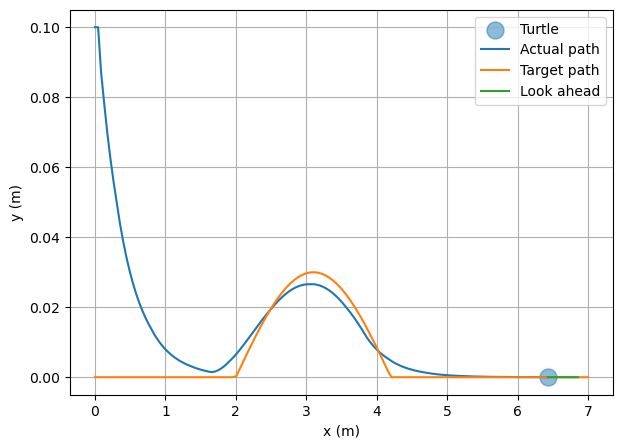

< --- Grading based on Turtlebot position --- >
Your Turtlebot followed the target path within 0.01 m mean absolute error

✅ Looking good, the error is quite low!


In [12]:
model = KinematicTurtle()
model.reset()
t = 43

t_data = np.arange(0,t,model.sample_time)
x_data = np.zeros_like(t_data)
y_data = np.zeros_like(t_data)

# Target path to follow
xt = np.linspace(0,7,num = t_data.shape[0])
yt = np.zeros_like(t_data)

# bump
a, b, amp = 2.0, 4.2, 0.03
mask = (xt >= a) & (xt <= b)
yt[mask] += amp * np.sin(np.pi * (xt[mask] - a)/(b - a))

model.y = 0.10 # starting offset

def live_plot(x, y, xl, yl, figsize=(7,5)):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    plt.scatter(x[-1], y[-1], s=150, alpha=0.5, label='Turtle')
    plt.plot(x, y, label= "Actual path")
    plt.plot(xt, yt, label="Target path")
    plt.plot(xl, yl, label="Look ahead")
    plt.grid(True)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.legend()
    plt.show();

x = []
y = []
# t_data.shape[0]
for i in range(t_data.shape[0]):
    # For grading
    x_data[i] = model.x
    y_data[i] = model.y
    [steer, xl, yl] = model.pure_pursuit(xt,yt)
    # For liveplotting
    x.append(model.x)
    y.append(model.y)
    live_plot(x, y, xl, yl)
    
    # For model updating
    model.vw_step(0.15, steer)

# Grading [THIS IS NOT AUTOMATIC GRADER, JUST TO ASSIST IN GRADING]
mae, passed = grader(2, y_data, yt, t_data.shape[0])
print('< --- Grading based on Turtlebot position --- >')
print('Your Turtlebot followed the target path within %.2f m mean absolute error' % (mae))
print()
if passed:
    print('✅ Looking good, the error is quite low!')
else:
    print('⚠️ Over 0.02 m mean absolute error. Improve your model to reduce the error.')

# Task 3: Tracking a vehicle with GPS (7p)

The simulation exercises thus far have featured an ideal world with no noise. In real world, all information is uncertain due to measurement errors. Even simple things such as determining the position of a vehicle can be excruciatingly difficult. Here, we utilise simulated noisy data of a vehicle acquired via GPS. A Kalman filter is applied to acquire more accurate information of the vehicle position. See the video on MyCourses for a basic introduction to Kalman filter.

1. Run the cell below. Observe the noisy GPS data and the real trajectory of the vehicle. Keep in mind the difference in scaling of the axes.

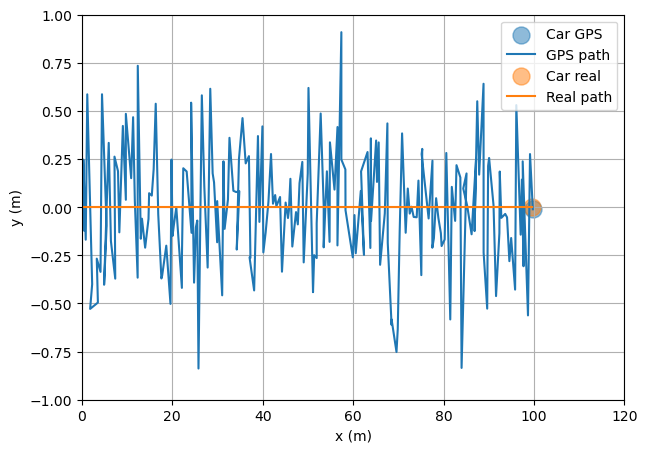

< --- GPS performance --- >
GPS positioned the car with a 0.36 m mean absolute error



In [20]:
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output
%matplotlib inline

np.random.seed(1)

# function to plot the GNSS data and the real track of the car
def live_plot(x1, y1, x2, y2, figsize=(7,5)):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    plt.scatter(x1[-1], y1[-1], s=150, alpha=0.5, label='Car GPS')
    plt.plot(x1, y1, label= "GPS path")
    plt.scatter(x2[-1], y2[-1], s=150, alpha=0.5, label='Car real')
    plt.plot(x2, y2, label="Real path")
    plt.grid(True)
    plt.axis([0, 120, -1, 1])
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.legend()
    plt.show();
    
# function for plotting the Kalman filtered result
def live_plot_kalman(x1, y1, x2, y2, figsize=(7,5)):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    plt.scatter(x1[-1], y1[-1], s=150, alpha=0.5, label='Car Kalman')
    plt.plot(x1, y1, label= "Kalman path")
    plt.scatter(x2[-1], y2[-1], s=150, alpha=0.5, label='Car real')
    plt.plot(x2, y2, label="Real path")
    plt.grid(True)
    plt.axis([0, 120, -1, 1])
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.legend()
    plt.show();
    
# function for plotting the velocity readings from the odometry 
def plot_velocity(vx1, vy1, vx2, vy2, x):
    fig, axs = plt.subplots(2, figsize = (8,6))
    axs[0].plot(x, vx1, label= "Real velocity")
    axs[0].plot(x, vx2, label= "Odometry measured velocity")
    axs[1].plot(x, vy1, label= "Real velocity")
    axs[1].plot(x, vy2, label= "Odometry measured velocity")
    
    axs[0].set_title('Velocity in x-direction')
    axs[1].set_title('Velocity in y-direction')
    axs[0].set(ylabel='v (m/s)')
    axs[1].set(ylabel='v (m/s)', xlabel='x (m)')
    axs[0].set_xlim([0, 120])
    axs[0].set_ylim([4, 6])
    axs[1].set_xlim([0, 120])
    axs[1].set_ylim([-1, 1])
    axs[0].grid(True)
    axs[1].grid(True)
    axs[0].legend()
    axs[1].legend()
    
    fig.tight_layout() 
    plt.show()

# sample interval of 0.1 s
dt = 0.1
# number of samples
n = 200
# generate real path of vehicle
x_real = np.linspace(0,100,n)
y_real = np.zeros(n)
# generate GPS data by adding Gaussian noise to the real path
x_gps = x_real + np.random.normal(0, 0.3, n)
y_gps = y_real + np.random.normal(0, 0.3, n)

# plot the GPS measurements and real path
for i in range(1,n):
    live_plot(x_gps[:i], y_gps[:i], x_real[:i], y_real[:i])
    # for reducing possible flickering
    time.sleep(0.02)
    
# Check GPS positioning accuracy
mae, passed = grader2(1, x_gps, y_gps, x_real, y_real)
print('< --- GPS performance --- >')
print('GPS positioned the car with a %.2f m mean absolute error' % (mae))
print()

Now, let's try to fix the noise in the positioning with a Kalman filter. The state $\mathbf{x}$ of the vehicle at sample $k$ is described by its x and y-coordinates, as well as the velocities in these respective directions.

$$\mathbf{x}_t = \begin{bmatrix} x_k \\ y_k \\ \dot{x}_k \\ \dot{y}_k \end{bmatrix}$$

Our simplistic vehicle model is as follows:

$$\mathbf{x}_k = \mathbf{A}\mathbf{x}_{k-1} + \mathbf{q}_{k-1}$$

where $\mathbf{A}$ is the state transition matrix 

$$\mathbf{A} = \begin{bmatrix} 1 & 0 & \Delta t & 0 \\ 0 & 1 & 0 & \Delta t \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix}$$

and $\mathbf{q}$ is the process noise, zero-mean Gaussian with a covariance $\mathbf{Q}$ of 

$$\mathbf{Q} = \begin{bmatrix} 10^{-4} & 0 & 0 & 0 \\ 0 & 10^{-4} & 0 & 0 \\ 0 & 0 & 10^{-4} & 0 \\ 0 & 0 & 0 & 10^{-4} \end{bmatrix}.$$

Our model to describe our GPS measurements $\mathbf{z}_k$ is the following:

$$\mathbf{z}_k = \mathbf{H}\mathbf{x}_k + \mathbf{r}_{k}$$

where $\mathbf{H}$ is our state-to-measurement matrix

$$\mathbf{H} = \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \end{bmatrix}$$

and $\mathbf{r}$ is the measurement noise, zero-mean Gaussian with a covariance $\mathbf{R}$ of

$$\mathbf{R} = \begin{bmatrix} 10^{-2} & 0 \\ 0 & 10^{-2} \end{bmatrix}.$$  

<br/><br/>

2. Create numpy arrays representing the matrices <code>A</code>, <code>Q</code>, and <code>H</code>. (**Hint**: The numpy array creation for matrix <code>R</code> has been provided as an example.) (**Hint2**: The sample time $\Delta t$ is provided in variable <code>dt</code>)

<br/><br/>

Running the Kalman filter will give us estimates of the state $\mathbf{x_k}$ by the mean $\mathbf{m_k}$ and covariance $\mathbf{P_k}$. These have to be initialised in order to start the filtering process. Let's initialize the mean $\mathbf{m}_{init}$ with a guess, that the positions $x,y$ and velocities $\dot{x}, \dot{y}$ are zero:

$$\mathbf{m}_{init} = \begin{bmatrix} 0 \\ 0 \\ 0 \\ 0 \end{bmatrix}$$

Let's also guess the initial state covariance $\mathbf{P}_{init}$:

$$\mathbf{P}_{init} = \begin{bmatrix} 10^{-1} & 0 & 0 & 0\\ 0 & 10^{-1} & 0 & 0 \\ 0 & 0 & 10^{-1} & 0 \\ 0 & 0 & 0 & 10^{-1}\end{bmatrix}$$

<br/><br/>

3. Initialize the estimate with mean <code>m</code> and covariance <code>P</code> numpy arrays.

Now the Kalman filter predict-update cycle can be executed. 

4. Use the system model to predict a new estimate for the mean <code>m</code> and covariance <code>P</code>. The prediction function has already been implemented, call it with the correct system-related input <code>kalman_predict(...)</code>. (**Hint**: Check the function definition.)

To perform the update step, we need the most recent GPS measurement. This is stored in the measurement vector as 

$$\mathbf{z}_k = \begin{bmatrix} x_{gps,k} \\ y_{gps,k} \end{bmatrix}$$

5. Insert the GPS measurements <code>x_gps[k]</code> and <code>y_gps[k]</code> to a numpy array representing the measurement vector <code>z</code>. Execute the update-step with the function <code>kalman_update(...)</code>. (**Hint**: Check the function definition.)

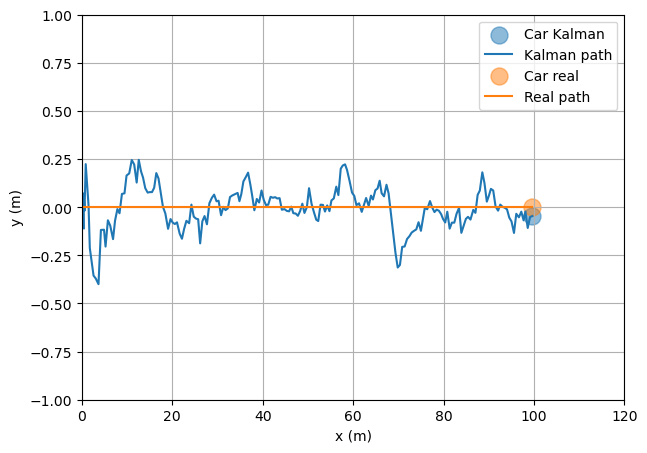

< --- Performance check based on tracking results --- >
Your filter reached a 0.14 m mean absolute error

✅ Looking good, the error is quite low!


In [22]:
# function to perform Kalman prediction step
def kalman_predict(m, P, A, Q):
    m = A @ m
    P = A @ P @ A.T + Q
    return m, P

# function to perform Kalman update step
def kalman_update(z, m, P, H, R):
    S = H @ P @ H.T + R
    K = P @ H.T @ np.linalg.inv(S)
    
    m = m + K @ (z - H @ m)
    P = P - K @ S @ K.T
    return m, P

################
R = np.array([[1e-2, 0],
             [0, 1e-2]])

R = np.array([[1e-2, 0],
              [0, 1e-2]])

#YOUR CODE HERE:
A = np.array([[1, 0, dt, 0],
              [0, 1, 0, dt],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])

Q = np.array([[1e-4, 0, 0, 0],
              [0, 1e-4, 0, 0],
              [0, 0, 1e-4, 0],
              [0, 0, 0, 1e-4]])

H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]])
################

################
#YOUR CODE HERE:
m = np.array([0, 0, 0, 0])
#m = np.transpose(m)
P = np.array([[1e-1, 0, 0, 0],
              [0, 1e-1, 0, 0],
              [0, 0, 1e-1, 0],
              [0, 0, 0, 1e-1]]) 
################


x_filtered = []
y_filtered = []

# loop through measurements, perform Kalman filtering 
for k in range(n):
    #################
    #YOUR CODE HERE:
    m, P = kalman_predict(m, P, A, Q)
    z = np.array([x_gps[k], y_gps[k]])
    
    m, P = kalman_update(z, m, P, H, R)
    ################
    
    x_filtered.append(float(m[0]))
    y_filtered.append(float(m[1]))
    
x_filtered = np.array(x_filtered)
y_filtered = np.array(y_filtered)

# plot the filtered vehicle path and real path
for i in range(1, n):
    live_plot_kalman(x_filtered[:i], y_filtered[:i], x_real[:i], y_real[:i])
    # for reducing possible flickering
    time.sleep(0.02)

# Result check [THIS IS NOT AN AUTOMATIC GRADER]
mae, passed = grader2(3, x_filtered, y_filtered, x_real, y_real)
print('< --- Performance check based on tracking results --- >')
print('Your filter reached a %.2f m mean absolute error' % (mae))
print()
if passed:
    print('✅ Looking good, the error is quite low!')
else:
    print('⚠️ Over 0.15 m mean absolute error. Something is probably wrong with the filter')

# Task 4: Tracking a vehicle with GPS and odometry
To overcome the short-comings of sensor data, it is typical to fuse readings from multiple sensors. This improves accuracy and robustness. Kalman filter is inherently capable of fusing measurements from different sensors.

Here, we build on the previous implementation. In addition to GPS position data, we now have velocity measurements from the vehicle odometry system. Like the GPS data, the velocity measurements are also noisy.  

1. Run the cell below to plot the noisy odometry data.

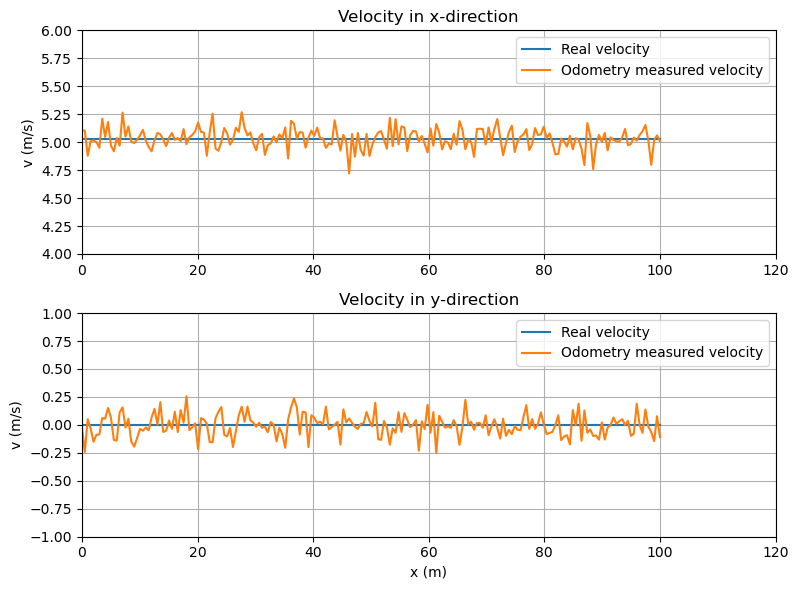

In [27]:
vx_real = ((x_real[1] - x_real[0])/dt) * np.ones(n)
vy_real = np.zeros(n)

vx_odom = vx_real + np.random.normal(0, 0.1, n)
vy_odom = vy_real + np.random.normal(0, 0.1, n)

plot_velocity(vx_real, vy_real, vx_odom, vy_odom, x_real)

In order to update our model to include the odometry data, we have to update the contents of our measurement model:

$$\mathbf{z}_k = \mathbf{H}\mathbf{x}_k + \mathbf{r}_{k}$$

More specifically, we have to update the state-to-measurement matrix $\mathbf{H}$ as well as the measurement noise covariance matrix $\mathbf{R}$. These matrices are now:

$$\mathbf{H} = \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix}$$

$$\mathbf{R} = \begin{bmatrix} 10^{-2} & 0 & 0 & 0 \\ 0 & 10^{-2} & 0 & 0 \\ 0 & 0 & 10^{-3} & 0 \\ 0 & 0 & 0 & 10^{-3} \end{bmatrix}$$  

<br/><br/>

2. Create new numpy arrays <code>H</code> and <code>R</code> to represent the updated measurement model.
3. Initialise the estimate mean <code>m</code> and covariance <code>P</code> like in the previous exercise.

With the addition of the odometry data, our measurement $\mathbf{z}$ now looks like

$$\mathbf{z}_k = \begin{bmatrix} x_{gps,k} \\ y_{gps,k} \\ \dot{x}_{odom,k} \\ \dot{y}_{odom,k} \end{bmatrix}$$

4. Run the filter: Perform prediction with <code>kalman_predict(...)</code>. Store latest measurement to <code>z</code>. Perform the update with <code>kalman_update(...)</code>.



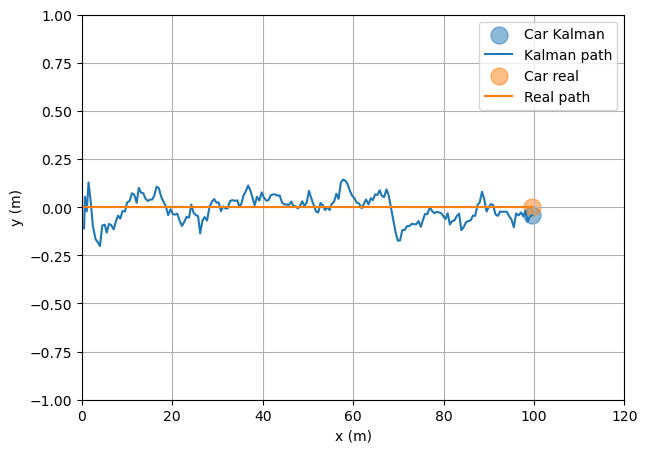

< --- Performance check based on tracking results --- >
Your filter reached a 0.08 m mean absolute error

✅ Looking good, the error is quite low!


In [29]:
################
#YOUR CODE HERE:
H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, 0],
              [0, 0, 0, 1]]) 
R = np.array([[1e-2, 0, 0, 0],
              [0, 1e-2, 0, 0],
              [0, 0, 1e-3, 0],
              [0, 0, 0, 1e-3]]) 
################

################
#YOUR CODE HERE:
m = np.array([0, 0, 0, 0])
#m = np.transpose(m)
P = np.array([[1e-1, 0, 0, 0],
              [0, 1e-1, 0, 0],
              [0, 0, 1e-1, 0],
              [0, 0, 0, 1e-1]]) 
################

x_filtered = []
y_filtered = []

for k in range(n):
    #################
    #YOUR CODE HERE:
    m, P = kalman_predict(m, P, A, Q)
    z = np.array([x_gps[k], y_gps[k], vx_odom[k], vy_odom[k]])

    m, P = kalman_update(z, m, P, H, R)
    ################
    
    x_filtered.append(float(m[0]))
    y_filtered.append(float(m[1]))
    
x_filtered = np.array(x_filtered)
y_filtered = np.array(y_filtered)

# plot the filtered vehicle path and real path
for i in range(1, n):
    live_plot_kalman(x_filtered[:i], y_filtered[:i], x_real[:i], y_real[:i])
    # for reducing possible flickering
    time.sleep(0.02)
    
# Result check [THIS IS NOT AN AUTOMATIC GRADER]
mae, passed = grader2(4, x_filtered, y_filtered, x_real, y_real)
print('< --- Performance check based on tracking results --- >')
print('Your filter reached a %.2f m mean absolute error' % (mae))
print()
if passed:
    print('✅ Looking good, the error is quite low!')
else:
    print('⚠️ Over 0.10 m mean absolute error. Something is probably wrong with the filter.')

Great online resources are available for those who want to dig deeper into Kalman filtering:  
https://thekalmanfilter.com/kalman-filter-explained-simply/  
https://www.kalmanfilter.net/default.aspx  

Recommended courses in Aalto for people interested in the details of Kalman Filtering (and other filtering techniques) include ELEC-E8740 Basics of Sensor Fusion D and ELEC-E8106 Bayesian Filtering and Smoothing D. The exercises here have derived inspiration from the course ELEC-E8106 Bayesian Filtering and Smoothing D by Simo Särkkä.

Congratulations for completing the exercise! :)

<b> Submit only this Jupyter Notebook file to MyCourses. </b>
